In [3]:
import torch
import clip
from PIL import Image
# 定义模型
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

image = preprocess(Image.open("../CLIP.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

Label probs: [[0.9927   0.004185 0.002968]]


```python
_MODELS = {
    "RN50": "https://openaipublic.azureedge.net/clip/models/afeb0e10f9e5a86da6080e35cf09123aca3b358a0c3e3b6c78a7b63bc04b6762/RN50.pt",
    "RN101": "https://openaipublic.azureedge.net/clip/models/8fa8567bab74a42d41c5915025a8e4538c3bdbe8804a470a72f30b0d94fab599/RN101.pt",
    "RN50x4": "https://openaipublic.azureedge.net/clip/models/7e526bd135e493cef0776de27d5f42653e6b4c8bf9e0f653bb11773263205fdd/RN50x4.pt",
    "RN50x16": "https://openaipublic.azureedge.net/clip/models/52378b407f34354e150460fe41077663dd5b39c54cd0bfd2b27167a4a06ec9aa/RN50x16.pt",
    "RN50x64": "https://openaipublic.azureedge.net/clip/models/be1cfb55d75a9666199fb2206c106743da0f6468c9d327f3e0d0a543a9919d9c/RN50x64.pt",
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
    "ViT-L/14": "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt",
    "ViT-L/14@336px": "https://openaipublic.azureedge.net/clip/models/3035c92b350959924f9f00213499208652fc7ea050643e8b385c2dac08641f02/ViT-L-14-336px.pt",
}

```

# clip模型判断是否是羽毛球
参考的是官方给出的应用
输入Image和text，在text中给出相应的分类提示，最后输出该image在不同文本提示下的类别概率。



In [4]:
# 定义模型
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device", device)
model, preprocess = clip.load("ViT-B/32", device=device)

# 加载数据
image = preprocess(Image.open("../1_image/badminton.png")).unsqueeze(0).to(device)
text = clip.tokenize(["badminton", "ball", "football"]).to(device)

# 将数据导入模型
with torch.no_grad():
    # 先对数据进行编码
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    # 再将完成编码后的特征输入至模型中，得出矩阵结果
    logits_per_image, logits_per_text = model(image, text)
    print("logtis_per_image: ", logits_per_image)
    print("logits_per_text: ", logits_per_text)
    # 最后用softmax输出概率
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print(f"Label probs: {probs}")

device cuda
logtis_per_image:  tensor([[33.4688, 26.0469, 23.0000]], device='cuda:0', dtype=torch.float16)
logits_per_text:  tensor([[33.4688],
        [26.0469],
        [23.0000]], device='cuda:0', dtype=torch.float16)
Label probs: [[9.995e-01 5.975e-04 2.837e-05]]


![badminton](https://www.huanghehao.cn/wp-content/uploads/2022/08/e5c2b4e3b6c5055231c8283fdfa41c81.jpg)


# clip模型zero-shot预测


In [5]:
import os
from torchvision.datasets import CIFAR100
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
model_B, preprocess_B = clip.load('ViT-B/32', device)
model_L, preprocess_L = clip.load('ViT-L/14@336px', device)

cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)


Files already downloaded and verified


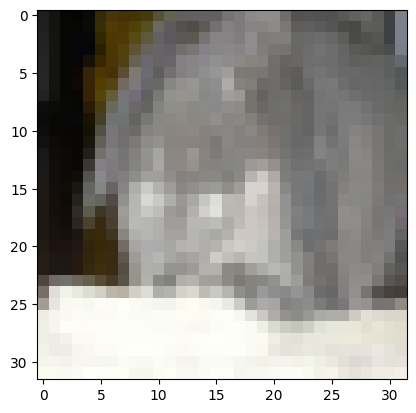

In [15]:
# 加载数据中的任意一张
# （1）从数据集中随机抽取⼀张图⽚，作为图⽚输⼊
# （2）取出该数据集下所有的标签，作为⽂字数据
image, class_id = cifar100[1000]
image_input = preprocess_B(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

plt.imshow(image)
plt.show()

In [16]:
# vit-B
with torch.no_grad():
    image_features = model_B.encode_image(image_input)
    text_features = model_B.encode_text(text_inputs)

# 分别对图像、⽂字特征向量做归⼀化处理，
# 然后计算余弦相似度
# 取最相似的top5结果
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Print the result
print("This is vit-B/32 results.")
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")

This is vit-B/32 results.

Top predictions:

        flatfish: 11.28%
           shrew: 9.80%
    sweet_pepper: 6.04%
          rabbit: 5.00%
   aquarium_fish: 3.90%


In [17]:
# vit-L
image_input = preprocess_L(image).unsqueeze(0).to(device)
with torch.no_grad():
    image_features = model_L.encode_image(image_input)
    text_features = model_L.encode_text(text_inputs)

# 分别对图像、⽂字特征向量做归⼀化处理，
# 然后计算余弦相似度
# 取最相似的top5结果
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Print the result
print("This is vit-L results.")
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")

This is vit-L results.

Top predictions:

          rabbit: 60.06%
           shrew: 10.12%
    sweet_pepper: 3.96%
       porcupine: 2.09%
           mouse: 1.53%


下面对图像进行逻辑回归

In [19]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
from tqdm import *

# Load the dataset
root = os.path.expanduser("~/.cache")
train = CIFAR100(root, download=True, train=True, transform=preprocess)
test = CIFAR100(root, download=True, train=False, transform=preprocess)

def get_features(dataset):
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()

# Calculate the image features
train_features, train_labels = get_features(train)
test_features, test_labels = get_features(test)

# Perform logistic regression
classifier = LogisticRegression(random_state=0, C=0.316, max_iter=1000, verbose=1)
classifier.fit(train_features, train_labels)

# Evaluate using the logistic regression classifier
predictions = classifier.predict(test_features)
accuracy = np.mean((test_labels == predictions).astype(float)) * 100.
print(f"Accuracy = {accuracy:.3f}")

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 100/100 [02:20<00:00,  1.40s/it]


Accuracy = 80.060
